# Spark on Google Colab Example
in this .......

## Download all the repo

In [2]:
# we download from repository
! git clone https://github.com/albertoisorna/Spark_on_GoogleColab.git
# we get into the folder
%cd Spark_on_GoogleColab

Cloning into 'Spark_on_GoogleColab'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.
/content/Spark_on_GoogleColab


## Installation
we will install :
- 
-
-


In [3]:
!chmod 777 install-all.sh
!./install-all.sh

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [92.5 kB]
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 k

## Start a Spark Session

In [0]:
import findspark
import os

spark_location='/root/spark-2.4.5-bin-hadoop2.7' # Set your own
java8_location= '/usr/lib/jvm/java-8-openjdk-amd64' # Set your own
session_name= 'my_example'
os.environ['JAVA_HOME'] = java8_location
findspark.init(spark_home=spark_location) 

from pyspark.sql import SparkSession
from pyspark.sql.types import StructField,StringType,IntegerType,FloatType,TimestampType,BooleanType,StructType

spark = SparkSession.builder.appName(session_name).getOrCreate()

## Read the dataset

In [0]:
# libraries for the Clustering
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [6]:
# read from CSV
datasetName = 'seeds_dataset.csv' # you can set your own dataset
dataset = spark.read.csv(datasetName, header=True, inferSchema=True)
# print SCHEMA
dataset.printSchema()

root
 |-- area: double (nullable = true)
 |-- perimeter: double (nullable = true)
 |-- compactness: double (nullable = true)
 |-- length_of_kernel: double (nullable = true)
 |-- width_of_kernel: double (nullable = true)
 |-- asymmetry_coefficient: double (nullable = true)
 |-- length_of_groove: double (nullable = true)



## Dataset formating

In [7]:
# asign columns namew
featurescol = 'features'
scaledcol   = 'scaledFeatures'

# assemble and # scale the features
assembler  = VectorAssembler(inputCols=dataset.columns, outputCol=featurescol)
scaler = StandardScaler(inputCol=featurescol, outputCol=scaledcol)

# transform the features and scale the data
final_data = assembler.transform(dataset)
final_scaled_data = scaler.fit(final_data).transform(final_data)

for el in final_scaled_data.columns:
  print(final_scaled_data.select(el))

DataFrame[area: double]
DataFrame[perimeter: double]
DataFrame[compactness: double]
DataFrame[length_of_kernel: double]
DataFrame[width_of_kernel: double]
DataFrame[asymmetry_coefficient: double]
DataFrame[length_of_groove: double]
DataFrame[features: vector]
DataFrame[scaledFeatures: vector]


## Build the Model and Transform in categories

In [8]:
# build KMeans structure 
kmeans = KMeans(featuresCol=scaledcol, k = 3)#

# fit the model
model = kmeans.fit(final_scaled_data)

# compute the WSSE
print(model.computeCost(final_scaled_data))

# Transform the data
df = model.transform(final_scaled_data)

428.60820118716356


### Plot the Clusters

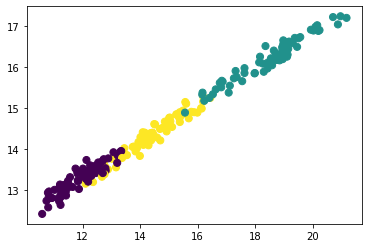

In [14]:
import matplotlib.pyplot as plt

def getArrayFromCol(col):
  return df.select(col).rdd.flatMap(lambda x: x).collect()

plt.scatter(getArrayFromCol('area'), getArrayFromCol('perimeter'), c=getArrayFromCol('prediction'), s=50, cmap='viridis')